# Ensemble methods

Ensemble methods in machine learning combine multiple individual models to create a stronger, more accurate predictive model. This approach leverages the diverse strengths of different models, mitigating errors and enhancing overall robustness. Popular techniques include bagging, boosting, and stacking, each with its own approach to combining predictions.

1. Bagging (Bootstrap Aggregating):  
    - Creates multiple subsets of the training data using bootstrap sampling.
    - Trains a separate model on each subset.
    - Combines the predictions (e.g., averaging for regression, voting for classification).
    - Reduces variance and overfitting.
    - A popular example is Random Forests, which uses decision trees as base models. 

2. Boosting:  
    - Trains models sequentially, with each model correcting the errors of its predecessors.
    - Each model's contribution is weighted based on its performance.
    - Reduces bias and improves accuracy.
    - Examples include AdaBoost and Gradient Boosting. 

3. Stacking (Stacked Generalization):  
    - Uses multiple diverse models (often of different types).
    - A meta-model (or "meta-learner") learns how to best combine the predictions of the base models.
    - Aims for better performance than any individual model.
    - Useful when different models excel at different aspects of the data. 

### Table of Contents
1. [Categorical Feature Support in Gradient Boosting](#Categorical-Feature-Support-in-Gradient-Boosting)
2. [Combine predictors using stacking](#Combine-predictors-using-stacking)
3. [Comparing Random Forests and Histogram Gradient Boosting models](#Comparing-Random-Forests-and-Histogram-Gradient-Boosting-models)
4. [Decision Tree Regression with AdaBoost](#decision-tree-regression-with-adaBoost)
5. [Early stopping in Gradient Boosting](#Early-stopping-in-Gradient-Boosting)
6. [Gradient Boosting regularization](#Gradient-Boosting-regularization)

<a name='Categorical-Feature-Support-in-Gradient-Boosting'></a>
## Categorical Feature Support in Gradient Boosting

In this example, we will compare the training times and prediction performances of `HistGradientBoostingRegressor` with different encoding strategies for categorical features. In particular, we will evaluate:

dropping the categorical features

using a `OneHotEncoder`

using an `OrdinalEncoder` and treat categories as ordered, equidistant quantities

using an `OrdinalEncoder` and rely on the native category support of the `HistGradientBoostingRegressor` estimator.

We will work with the Ames Iowa Housing dataset which consists of numerical and categorical features, where the houses’ sales prices is the target.

See Features in Histogram Gradient Boosting Trees for an example showcasing some other features of `HistGradientBoostingRegressor`.

### Load Ames Housing dataset
First, we load the Ames Housing data as a pandas dataframe. The features are either categorical or numerical:

In [1]:
from sklearn.datasets import fetch_openml

X, y = fetch_openml(data_id=42165, as_frame=True, return_X_y=True)

# Select only a subset of features of X to make the example faster to run
categorical_columns_subset = [
    "BldgType",
    "GarageFinish",
    "LotConfig",
    "Functional",
    "MasVnrType",
    "HouseStyle",
    "FireplaceQu",
    "ExterCond",
    "ExterQual",
    "PoolQC",
]

numerical_columns_subset = [
    "3SsnPorch",
    "Fireplaces",
    "BsmtHalfBath",
    "HalfBath",
    "GarageCars",
    "TotRmsAbvGrd",
    "BsmtFinSF1",
    "BsmtFinSF2",
    "GrLivArea",
    "ScreenPorch",
]

X = X[categorical_columns_subset + numerical_columns_subset]
X[categorical_columns_subset] = X[categorical_columns_subset].astype("category")

categorical_columns = X.select_dtypes(include="category").columns
n_categorical_features = len(categorical_columns)
n_numerical_features = X.select_dtypes(include="number").shape[1]

print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of categorical features: {n_categorical_features}")
print(f"Number of numerical features: {n_numerical_features}")

Number of samples: 1460
Number of features: 20
Number of categorical features: 10
Number of numerical features: 10


### Gradient boosting estimator with dropped categorical features
As a baseline, we create an estimator where the categorical features are dropped:

In [10]:
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline

dropper = make_column_transformer(
    ("drop", make_column_selector(dtype_include="category")), remainder="passthrough"
)
hist_dropped = make_pipeline(dropper, HistGradientBoostingRegressor(random_state=42))

### Gradient boosting estimator with one-hot encoding
Next, we create a pipeline that will one-hot encode the categorical features and let the rest of the numerical data to passthrough:

In [11]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
)

hist_one_hot = make_pipeline(
    one_hot_encoder, HistGradientBoostingRegressor(random_state=42)
)

### Gradient boosting estimator with ordinal encoding
Next, we create a pipeline that will treat categorical features as if they were ordered quantities, i.e. the categories will be encoded as 0, 1, 2, etc., and treated as continuous features.

In [12]:
import numpy as np

from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = make_column_transformer(
    (
        OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=np.nan),
        make_column_selector(dtype_include="category"),
    ),
    remainder="passthrough",
    # Use short feature names to make it easier to specify the categorical
    # variables in the HistGradientBoostingRegressor in the next step
    # of the pipeline.
    verbose_feature_names_out=False,
)

hist_ordinal = make_pipeline(
    ordinal_encoder, HistGradientBoostingRegressor(random_state=42)
)

### Gradient boosting estimator with native categorical support
We now create a `HistGradientBoostingRegressor` estimator that will natively handle categorical features. This estimator will not treat categorical features as ordered quantities. We set categorical_features="from_dtype" such that features with categorical dtype are considered categorical features.

The main difference between this estimator and the previous one is that in this one, we let the `HistGradientBoostingRegressor` detect which features are categorical from the DataFrame columns’ dtypes.

In [13]:
hist_native = HistGradientBoostingRegressor(
    random_state=42, categorical_features="from_dtype"
)

### Model comparison
Finally, we evaluate the models using cross validation. Here we compare the models performance in terms of `mean_absolute_percentage_error` and fit times.

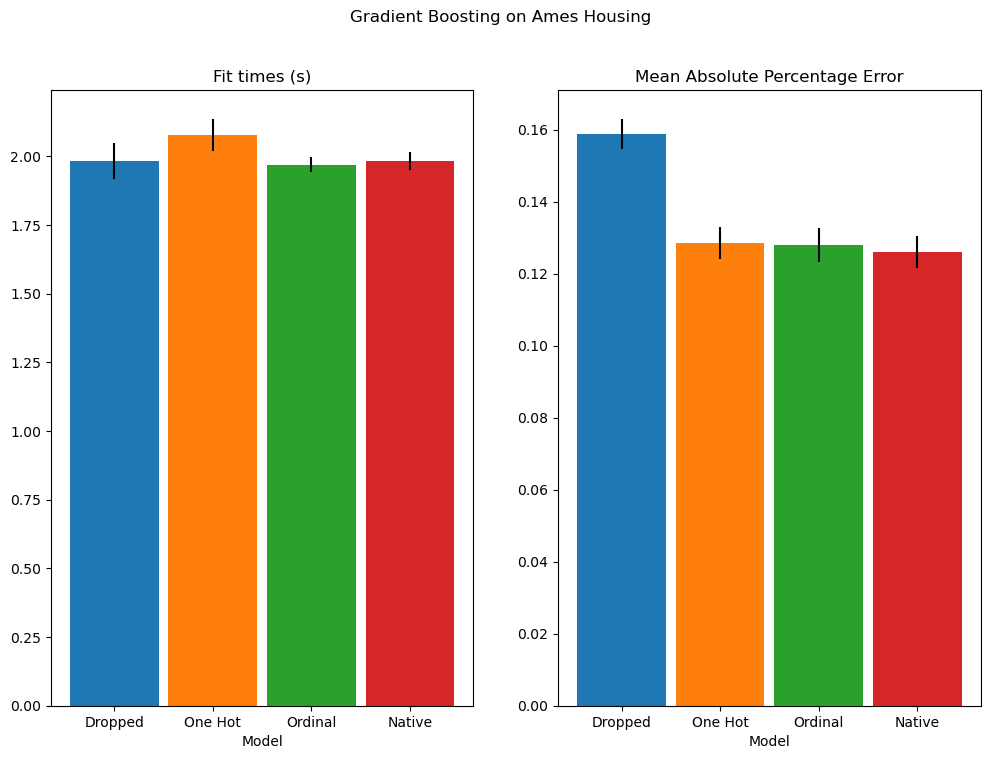

In [14]:
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_validate

scoring = "neg_mean_absolute_percentage_error"
n_cv_folds = 3

dropped_result = cross_validate(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)


def plot_results(figure_title):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

    plot_info = [
        ("fit_time", "Fit times (s)", ax1, None),
        ("test_score", "Mean Absolute Percentage Error", ax2, None),
    ]

    x, width = np.arange(4), 0.9
    for key, title, ax, y_limit in plot_info:
        items = [
            dropped_result[key],
            one_hot_result[key],
            ordinal_result[key],
            native_result[key],
        ]

        mape_cv_mean = [np.mean(np.abs(item)) for item in items]
        mape_cv_std = [np.std(item) for item in items]

        ax.bar(
            x=x,
            height=mape_cv_mean,
            width=width,
            yerr=mape_cv_std,
            color=["C0", "C1", "C2", "C3"],
        )
        ax.set(
            xlabel="Model",
            title=title,
            xticks=x,
            xticklabels=["Dropped", "One Hot", "Ordinal", "Native"],
            ylim=y_limit,
        )
    fig.suptitle(figure_title)


plot_results("Gradient Boosting on Ames Housing")

We see that the model with one-hot-encoded data is by far the slowest. This is to be expected, since one-hot-encoding creates one additional feature per category value (for each categorical feature), and thus more split points need to be considered during fitting. In theory, we expect the native handling of categorical features to be slightly slower than treating categories as ordered quantities (‘Ordinal’), since native handling requires sorting categories. Fitting times should however be close when the number of categories is small, and this may not always be reflected in practice.

In terms of prediction performance, dropping the categorical features leads to poorer performance. The three models that use categorical features have comparable error rates, with a slight edge for the native handling.



### Limiting the number of splits
In general, one can expect poorer predictions from one-hot-encoded data, especially when the tree depths or the number of nodes are limited: with one-hot-encoded data, one needs more split points, i.e. more depth, in order to recover an equivalent split that could be obtained in one single split point with native handling.

This is also true when categories are treated as ordinal quantities: if categories are `A..F` and the best split is `ACF - BDE` the one-hot-encoder model will need 3 split points (one per category in the left node), and the ordinal non-native model will need 4 splits: 1 split to isolate `A`, 1 split to isolate `F`, and 2 splits to isolate `C` from `BCDE`.

How strongly the models’ performances differ in practice will depend on the dataset and on the flexibility of the trees.

To see this, let us re-run the same analysis with under-fitting models where we artificially limit the total number of splits by both limiting the number of trees and the depth of each tree.

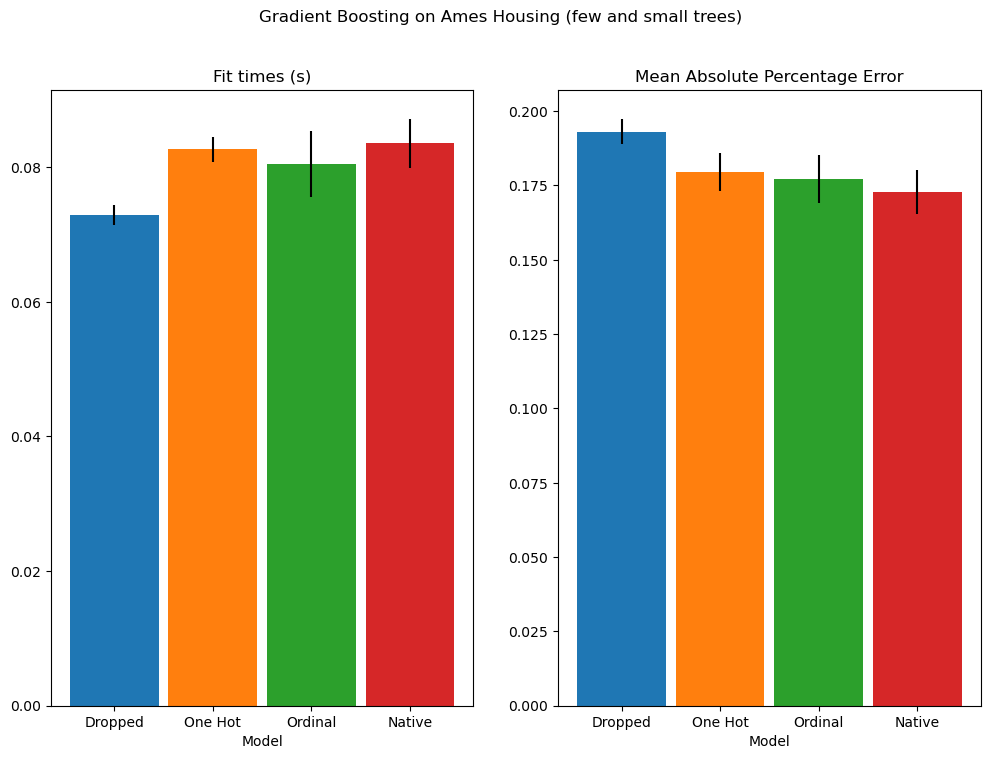

In [15]:
for pipe in (hist_dropped, hist_one_hot, hist_ordinal, hist_native):
    if pipe is hist_native:
        # The native model does not use a pipeline so, we can set the parameters
        # directly.
        pipe.set_params(max_depth=3, max_iter=15)
    else:
        pipe.set_params(
            histgradientboostingregressor__max_depth=3,
            histgradientboostingregressor__max_iter=15,
        )

dropped_result = cross_validate(hist_dropped, X, y, cv=n_cv_folds, scoring=scoring)
one_hot_result = cross_validate(hist_one_hot, X, y, cv=n_cv_folds, scoring=scoring)
ordinal_result = cross_validate(hist_ordinal, X, y, cv=n_cv_folds, scoring=scoring)
native_result = cross_validate(hist_native, X, y, cv=n_cv_folds, scoring=scoring)

plot_results("Gradient Boosting on Ames Housing (few and small trees)")

plt.show()

The results for these under-fitting models confirm our previous intuition: the native category handling strategy performs the best when the splitting budget is constrained. The two other strategies (one-hot encoding and treating categories as ordinal values) lead to error values comparable to the baseline model that just dropped the categorical features altogether.



## Combine predictors using stacking

Stacking refers to a method to blend estimators. In this strategy, some estimators are individually fitted on some training data while a final estimator is trained using the stacked predictions of these base estimators.

In this example, we illustrate the use case in which different regressors are stacked together and a final linear penalized regressor is used to output the prediction. We compare the performance of each individual regressor with the stacking strategy. Stacking slightly improves the overall performance.

### Download the dataset
We will use the Ames Housing dataset which was first compiled by Dean De Cock and became better known after it was used in Kaggle challenge. It is a set of 1460 residential homes in Ames, Iowa, each described by 80 features. We will use it to predict the final logarithmic price of the houses. In this example we will use only 20 most interesting features chosen using GradientBoostingRegressor() and limit number of entries (here we won’t go into the details on how to select the most interesting features).

The Ames housing dataset is not shipped with scikit-learn and therefore we will fetch it from OpenML.



In [16]:
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle


def load_ames_housing():
    df = fetch_openml(name="house_prices", as_frame=True)
    X = df.data
    y = df.target

    features = [
        "YrSold",
        "HeatingQC",
        "Street",
        "YearRemodAdd",
        "Heating",
        "MasVnrType",
        "BsmtUnfSF",
        "Foundation",
        "MasVnrArea",
        "MSSubClass",
        "ExterQual",
        "Condition2",
        "GarageCars",
        "GarageType",
        "OverallQual",
        "TotalBsmtSF",
        "BsmtFinSF1",
        "HouseStyle",
        "MiscFeature",
        "MoSold",
    ]

    X = X.loc[:, features]
    X, y = shuffle(X, y, random_state=0)

    X = X.iloc[:600]
    y = y.iloc[:600]
    return X, np.log(y)


X, y = load_ames_housing()

### Make pipeline to preprocess the data
Before we can use Ames dataset we still need to do some preprocessing. First, we will select the categorical and numerical columns of the dataset to construct the first step of the pipeline.



In [17]:
from sklearn.compose import make_column_selector

cat_selector = make_column_selector(dtype_include=object)
num_selector = make_column_selector(dtype_include=np.number)
cat_selector(X)

['HeatingQC',
 'Street',
 'Heating',
 'MasVnrType',
 'Foundation',
 'ExterQual',
 'Condition2',
 'GarageType',
 'HouseStyle',
 'MiscFeature']

In [18]:
num_selector(X)

['YrSold',
 'YearRemodAdd',
 'BsmtUnfSF',
 'MasVnrArea',
 'MSSubClass',
 'GarageCars',
 'OverallQual',
 'TotalBsmtSF',
 'BsmtFinSF1',
 'MoSold']

Then, we will need to design preprocessing pipelines which depends on the ending regressor. If the ending regressor is a linear model, one needs to one-hot encode the categories. If the ending regressor is a tree-based model an ordinal encoder will be sufficient. Besides, numerical values need to be standardized for a linear model while the raw numerical data can be treated as is by a tree-based model. However, both models need an imputer to handle missing values.

We will first design the pipeline required for the tree-based models.

In [19]:
from sklearn.compose import make_column_transformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OrdinalEncoder

cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value",
    unknown_value=-1,
    encoded_missing_value=-2,
)
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
)
tree_preprocessor

,transformers,"[('simpleimputer', ...), ('ordinalencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,missing_values,nan
,strategy,'mean'
,fill_value,None


Then, we will now define the preprocessor used when the ending regressor is a linear model.



In [20]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
num_linear_processor = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="mean", add_indicator=True)
)

linear_preprocessor = make_column_transformer(
    (num_linear_processor, num_selector), (cat_linear_processor, cat_selector)
)
linear_preprocessor

,transformers,"[('pipeline', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


### Stack of predictors on a single data set
It is sometimes tedious to find the model which will best perform on a given dataset. Stacking provide an alternative by combining the outputs of several learners, without the need to choose a model specifically. The performance of stacking is usually close to the best model and sometimes it can outperform the prediction performance of each individual model.

Here, we combine 3 learners (linear and non-linear) and use a ridge regressor to combine their outputs together.

#### Note

Although we will make new pipelines with the processors which we wrote in the previous section for the 3 learners, the final estimator RidgeCV() does not need preprocessing of the data as it will be fed with the already preprocessed output from the 3 learners.

In [21]:
from sklearn.linear_model import LassoCV

lasso_pipeline = make_pipeline(linear_preprocessor, LassoCV())
lasso_pipeline

,steps,"[('columntransformer', ...), ('lassocv', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('pipeline', ...), ('onehotencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [22]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
rf_pipeline

,steps,"[('columntransformer', ...), ('randomforestregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('simpleimputer', ...), ('ordinalencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [23]:
from sklearn.ensemble import HistGradientBoostingRegressor

gbdt_pipeline = make_pipeline(
    tree_preprocessor, HistGradientBoostingRegressor(random_state=0)
)
gbdt_pipeline

,steps,"[('columntransformer', ...), ('histgradientboostingregressor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('simpleimputer', ...), ('ordinalencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [24]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

estimators = [
    ("Random Forest", rf_pipeline),
    ("Lasso", lasso_pipeline),
    ("Gradient Boosting", gbdt_pipeline),
]

stacking_regressor = StackingRegressor(estimators=estimators, final_estimator=RidgeCV())
stacking_regressor

,estimators,"[('Random Forest', ...), ('Lasso', ...), ...]"
,final_estimator,RidgeCV()
,cv,None
,n_jobs,None
,passthrough,False
,verbose,0
,transformers,"[('simpleimputer', ...), ('ordinalencoder', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None


### Measure and plot the results
Now we can use Ames Housing dataset to make the predictions. We check the performance of each individual predictor as well as of the stack of the regressors.

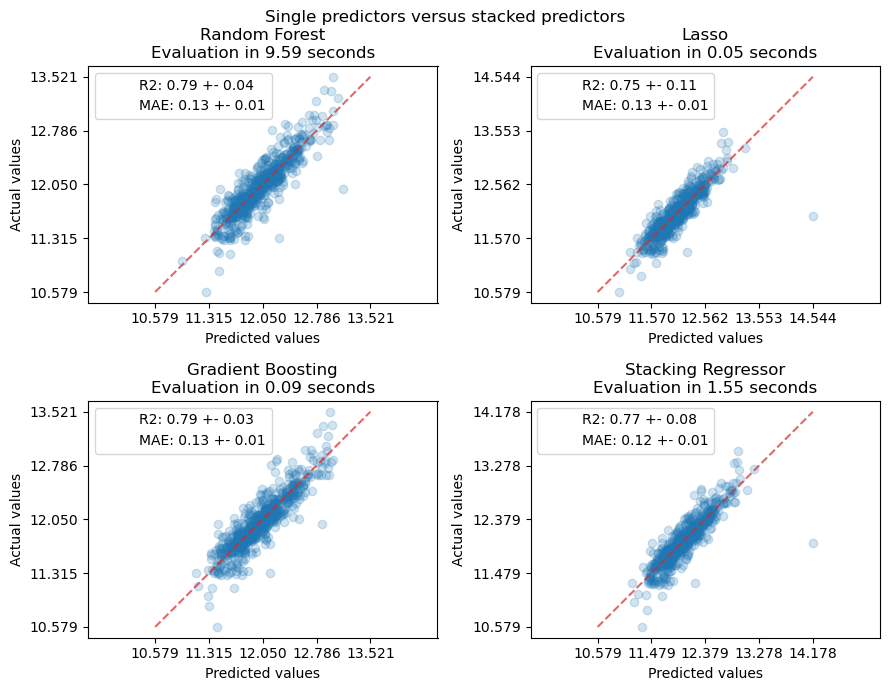

In [25]:
import time

import matplotlib.pyplot as plt

from sklearn.metrics import PredictionErrorDisplay
from sklearn.model_selection import cross_val_predict, cross_validate

fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)

for ax, (name, est) in zip(
    axs, estimators + [("Stacking Regressor", stacking_regressor)]
):
    scorers = {"R2": "r2", "MAE": "neg_mean_absolute_error"}

    start_time = time.time()
    scores = cross_validate(
        est, X, y, scoring=list(scorers.values()), n_jobs=-1, verbose=0
    )
    elapsed_time = time.time() - start_time

    y_pred = cross_val_predict(est, X, y, n_jobs=-1, verbose=0)
    scores = {
        key: (
            f"{np.abs(np.mean(scores[f'test_{value}'])):.2f} +- "
            f"{np.std(scores[f'test_{value}']):.2f}"
        )
        for key, value in scorers.items()
    }

    display = PredictionErrorDisplay.from_predictions(
        y_true=y,
        y_pred=y_pred,
        kind="actual_vs_predicted",
        ax=ax,
        scatter_kwargs={"alpha": 0.2, "color": "tab:blue"},
        line_kwargs={"color": "tab:red"},
    )
    ax.set_title(f"{name}\nEvaluation in {elapsed_time:.2f} seconds")

    for name, score in scores.items():
        ax.plot([], [], " ", label=f"{name}: {score}")
    ax.legend(loc="upper left")

plt.suptitle("Single predictors versus stacked predictors")
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

The stacked regressor will combine the strengths of the different regressors. However, we also see that training the stacked regressor is much more computationally expensive.

## Comparing Random Forests and Histogram Gradient Boosting models

In this example we compare the performance of Random Forest (RF) and Histogram Gradient Boosting (HGBT) models in terms of score and computation time for a regression dataset, though all the concepts here presented apply to classification as well.

The comparison is made by varying the parameters that control the number of trees according to each estimator:

- `n_estimators` controls the number of trees in the forest. It’s a fixed number.

- `max_iter` is the maximum number of iterations in a gradient boosting based model. The number of iterations corresponds to the number of trees for regression and binary classification problems. Furthermore, the actual number of trees required by the model depends on the stopping criteria.

HGBT uses gradient boosting to iteratively improve the model’s performance by fitting each tree to the negative gradient of the loss function with respect to the predicted value. RFs, on the other hand, are based on bagging and use a majority vote to predict the outcome.

See the User Guide for more information on ensemble models or see Features in Histogram Gradient Boosting Trees for an example showcasing some other features of HGBT models.

### Load dataset

HGBT uses a histogram-based algorithm on binned feature values that can efficiently handle large datasets (tens of thousands of samples or more) with a high number of features (see Why it’s faster). The scikit-learn implementation of RF does not use binning and relies on exact splitting, which can be computationally expensive.

In [1]:
from sklearn.datasets import fetch_california_housing

X, y = fetch_california_housing(return_X_y=True, as_frame=True)
n_samples, n_features = X.shape

print(f"The dataset consists of {n_samples} samples and {n_features} features")

The dataset consists of 20640 samples and 8 features


### Compute score and computation times
Notice that many parts of the implementation of `HistGradientBoostingClassifier` and `HistGradientBoostingRegressor` are parallelized by default.

The implementation of `RandomForestRegressor` and `RandomForestClassifier` can also be run on multiple cores by using the `n_jobs` parameter, here set to match the number of physical cores on the host machine. See Parallelism for more information.

In [2]:
import joblib

N_CORES = joblib.cpu_count(only_physical_cores=True)
print(f"Number of physical cores: {N_CORES}")

Number of physical cores: 10


Unlike RF, HGBT models offer an early-stopping option (see Early stopping in Gradient Boosting) to avoid adding new unnecessary trees. Internally, the algorithm uses an out-of-sample set to compute the generalization performance of the model at each addition of a tree. Thus, if the generalization performance is not improving for more than `n_iter_no_change` iterations, it stops adding trees.

The other parameters of both models were tuned but the procedure is not shown here to keep the example simple.

In [3]:
import pandas as pd

from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

models = {
    "Random Forest": RandomForestRegressor(
        min_samples_leaf=5, random_state=0, n_jobs=N_CORES
    ),
    "Hist Gradient Boosting": HistGradientBoostingRegressor(
        max_leaf_nodes=15, random_state=0, early_stopping=False
    ),
}
param_grids = {
    "Random Forest": {"n_estimators": [10, 20, 50, 100]},
    "Hist Gradient Boosting": {"max_iter": [10, 20, 50, 100, 300, 500]},
}
cv = KFold(n_splits=4, shuffle=True, random_state=0)

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        return_train_score=True,
        cv=cv,
    ).fit(X, y)
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

#### Note

Tuning the `n_estimators` for RF generally results in a waste of computer power. In practice one just needs to ensure that it is large enough so that doubling its value does not lead to a significant improvement of the testing score.

### Plot results
We can use a plotly.express.scatter to visualize the trade-off between elapsed computing time and mean test score. Passing the cursor over a given point displays the corresponding parameters. Error bars correspond to one standard deviation as computed in the different folds of the cross-validation.

In [4]:
import plotly.colors as colors
import plotly.express as px
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1,
    cols=2,
    shared_yaxes=True,
    subplot_titles=["Train time vs score", "Predict time vs score"],
)
model_names = [result["model"] for result in results]
colors_list = colors.qualitative.Plotly * (
    len(model_names) // len(colors.qualitative.Plotly) + 1
)

for idx, result in enumerate(results):
    cv_results = result["cv_results"].round(3)
    model_name = result["model"]
    param_name = next(iter(param_grids[model_name].keys()))
    cv_results[param_name] = cv_results["param_" + param_name]
    cv_results["model"] = model_name

    scatter_fig = px.scatter(
        cv_results,
        x="mean_fit_time",
        y="mean_test_score",
        error_x="std_fit_time",
        error_y="std_test_score",
        hover_data=param_name,
        color="model",
    )
    line_fig = px.line(
        cv_results,
        x="mean_fit_time",
        y="mean_test_score",
    )

    scatter_trace = scatter_fig["data"][0]
    line_trace = line_fig["data"][0]
    scatter_trace.update(marker=dict(color=colors_list[idx]))
    line_trace.update(line=dict(color=colors_list[idx]))
    fig.add_trace(scatter_trace, row=1, col=1)
    fig.add_trace(line_trace, row=1, col=1)

    scatter_fig = px.scatter(
        cv_results,
        x="mean_score_time",
        y="mean_test_score",
        error_x="std_score_time",
        error_y="std_test_score",
        hover_data=param_name,
    )
    line_fig = px.line(
        cv_results,
        x="mean_score_time",
        y="mean_test_score",
    )

    scatter_trace = scatter_fig["data"][0]
    line_trace = line_fig["data"][0]
    scatter_trace.update(marker=dict(color=colors_list[idx]))
    line_trace.update(line=dict(color=colors_list[idx]))
    fig.add_trace(scatter_trace, row=1, col=2)
    fig.add_trace(line_trace, row=1, col=2)

fig.update_layout(
    xaxis=dict(title="Train time (s) - lower is better"),
    yaxis=dict(title="Test R2 score - higher is better"),
    xaxis2=dict(title="Predict time (s) - lower is better"),
    legend=dict(x=0.72, y=0.05, traceorder="normal", borderwidth=1),
    title=dict(x=0.5, text="Speed-score trade-off of tree-based ensembles"),
)

Both HGBT and RF models improve when increasing the number of trees in the ensemble. However, the scores reach a plateau where adding new trees just makes fitting and scoring slower. The RF model reaches such plateau earlier and can never reach the test score of the largest HGBDT model.

Note that the results shown on the above plot can change slightly across runs and even more significantly when running on other machines: try to run this example on your own local machine.

Overall, one should often observe that the Histogram-based gradient boosting models uniformly dominate the Random Forest models in the “test score vs training speed trade-off” (the HGBDT curve should be on the top left of the RF curve, without ever crossing). The “test score vs prediction speed” trade-off can also be more disputed, but it’s most often favorable to HGBDT. It’s always a good idea to check both kinds of model (with hyper-parameter tuning) and compare their performance on your specific problem to determine which model is the best fit but HGBT almost always offers a more favorable speed-accuracy trade-off than RF, either with the default hyper-parameters or including the hyper-parameter tuning cost.

There is one exception to this rule of thumb though: when training a multiclass classification model with a large number of possible classes, HGBDT fits internally one-tree per class at each boosting iteration while the trees used by the RF models are naturally multiclass which should improve the speed accuracy trade-off of the RF models in this case.

<a name='decision-tree-regression-with-adaBoost'></a>

## Decision Tree Regression with AdaBoost

A decision tree is boosted using the AdaBoost.R2 [1] algorithm on a 1D sinusoidal dataset with a small amount of Gaussian noise. 299 boosts (300 decision trees) is compared with a single decision tree regressor. As the number of boosts is increased the regressor can fit more detail.

See Features in Histogram Gradient Boosting Trees for an example showcasing the benefits of using more efficient regression models such as `HistGradientBoostingRegressor`.

[1] H. Drucker, “Improving Regressors using Boosting Techniques”, 1997.

### Preparing the data
First, we prepare dummy data with a sinusoidal relationship and some gaussian noise.



In [12]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import numpy as np

rng = np.random.RandomState(1)
X = np.linspace(0, 6, 100)[:, np.newaxis]
y = np.sin(X).ravel() + np.sin(6 * X).ravel() + rng.normal(0, 0.1, X.shape[0])

### Training and prediction with DecisionTree and AdaBoost Regressors
Now, we define the classifiers and fit them to the data. Then we predict on that same data to see how well they could fit it. The first regressor is a `DecisionTreeRegressor` with `max_depth=4`. The second regressor is an `AdaBoostRegressor` with a `DecisionTreeRegressor` of `max_depth=4` as base learner and will be built with `n_estimators=300` of those base learners.

In [15]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

regr_1 = DecisionTreeRegressor(max_depth=4)

regr_2 = AdaBoostRegressor(
    DecisionTreeRegressor(max_depth=4), n_estimators=300, random_state=rng
)

regr_1.fit(X, y)
regr_2.fit(X, y)

y_1 = regr_1.predict(X)
y_2 = regr_2.predict(X)

### Plotting the results
Finally, we plot how well our two regressors, single decision tree regressor and AdaBoost regressor, could fit the data.

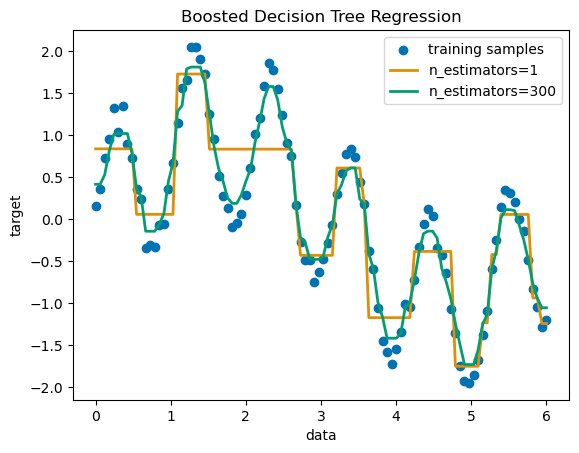

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

colors = sns.color_palette("colorblind")

plt.figure()
plt.scatter(X, y, color=colors[0], label="training samples")
plt.plot(X, y_1, color=colors[1], label="n_estimators=1", linewidth=2)
plt.plot(X, y_2, color=colors[2], label="n_estimators=300", linewidth=2)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Boosted Decision Tree Regression")
plt.legend()
plt.show()

<a name='Early-stopping-in-Gradient-Boosting'></a>
## Early stopping in Gradient Boosting

https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html

Gradient Boosting is an ensemble technique that combines multiple weak learners, typically decision trees, to create a robust and powerful predictive model. It does so in an iterative fashion, where each new stage (tree) corrects the errors of the previous ones.

Early stopping is a technique in Gradient Boosting that allows us to find the optimal number of iterations required to build a model that generalizes well to unseen data and avoids overfitting. The concept is simple: we set aside a portion of our dataset as a validation set (specified using validation_fraction) to assess the model’s performance during training. As the model is iteratively built with additional stages (trees), its performance on the validation set is monitored as a function of the number of steps.

Early stopping becomes effective when the model’s performance on the validation set plateaus or worsens (within deviations specified by tol) over a certain number of consecutive stages (specified by n_iter_no_change). This signals that the model has reached a point where further iterations may lead to overfitting, and it’s time to stop training.

The number of estimators (trees) in the final model, when early stopping is applied, can be accessed using the n_estimators_ attribute. Overall, early stopping is a valuable tool to strike a balance between model performance and efficiency in gradient boosting.

### Data Preparation
First we load and prepares the California Housing Prices dataset for training and evaluation. It subsets the dataset, splits it into training and validation sets.

In [17]:
import time

import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

data = fetch_california_housing()
X, y = data.data[:600], data.target[:600]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Training and Comparison
Two `GradientBoostingRegressor` models are trained: one with and another without early stopping. The purpose is to compare their performance. It also calculates the training time and the `n_estimators_` used by both models.

In [18]:
params = dict(n_estimators=1000, max_depth=5, learning_rate=0.1, random_state=42)

gbm_full = GradientBoostingRegressor(**params)
gbm_early_stopping = GradientBoostingRegressor(
    **params,
    validation_fraction=0.1,
    n_iter_no_change=10,
)

start_time = time.time()
gbm_full.fit(X_train, y_train)
training_time_full = time.time() - start_time
n_estimators_full = gbm_full.n_estimators_

start_time = time.time()
gbm_early_stopping.fit(X_train, y_train)
training_time_early_stopping = time.time() - start_time
estimators_early_stopping = gbm_early_stopping.n_estimators_

### Error Calculation
The code calculates the `mean_squared_error` for both training and validation datasets for the models trained in the previous section. It computes the errors for each boosting iteration. The purpose is to assess the performance and convergence of the models.

In [19]:
train_errors_without = []
val_errors_without = []

train_errors_with = []
val_errors_with = []

for i, (train_pred, val_pred) in enumerate(
    zip(
        gbm_full.staged_predict(X_train),
        gbm_full.staged_predict(X_val),
    )
):
    train_errors_without.append(mean_squared_error(y_train, train_pred))
    val_errors_without.append(mean_squared_error(y_val, val_pred))

for i, (train_pred, val_pred) in enumerate(
    zip(
        gbm_early_stopping.staged_predict(X_train),
        gbm_early_stopping.staged_predict(X_val),
    )
):
    train_errors_with.append(mean_squared_error(y_train, train_pred))
    val_errors_with.append(mean_squared_error(y_val, val_pred))

### Visualize Comparison
It includes three subplots:

Plotting training errors of both models over boosting iterations.

Plotting validation errors of both models over boosting iterations.

Creating a bar chart to compare the training times and the estimator used of the models with and without early stopping.

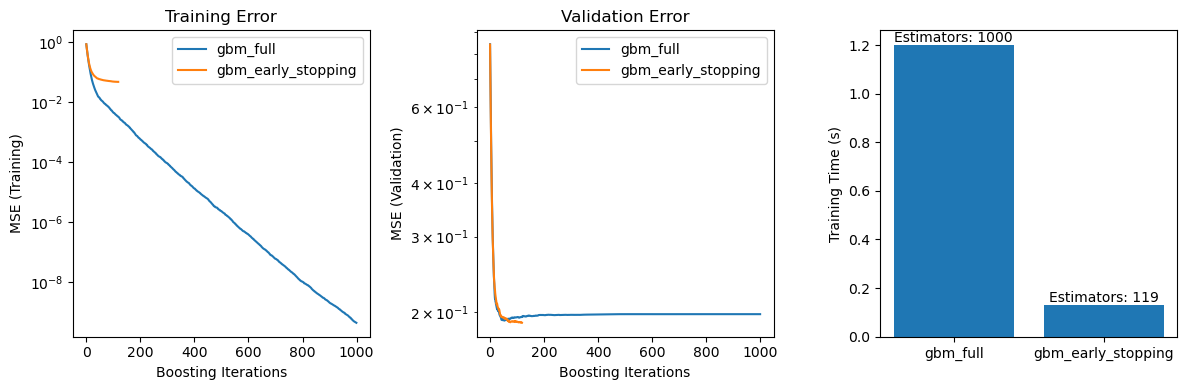

In [20]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))

axes[0].plot(train_errors_without, label="gbm_full")
axes[0].plot(train_errors_with, label="gbm_early_stopping")
axes[0].set_xlabel("Boosting Iterations")
axes[0].set_ylabel("MSE (Training)")
axes[0].set_yscale("log")
axes[0].legend()
axes[0].set_title("Training Error")

axes[1].plot(val_errors_without, label="gbm_full")
axes[1].plot(val_errors_with, label="gbm_early_stopping")
axes[1].set_xlabel("Boosting Iterations")
axes[1].set_ylabel("MSE (Validation)")
axes[1].set_yscale("log")
axes[1].legend()
axes[1].set_title("Validation Error")

training_times = [training_time_full, training_time_early_stopping]
labels = ["gbm_full", "gbm_early_stopping"]
bars = axes[2].bar(labels, training_times)
axes[2].set_ylabel("Training Time (s)")

for bar, n_estimators in zip(bars, [n_estimators_full, estimators_early_stopping]):
    height = bar.get_height()
    axes[2].text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.001,
        f"Estimators: {n_estimators}",
        ha="center",
        va="bottom",
    )

plt.tight_layout()
plt.show()

The difference in training error between the `gbm_full` and the `gbm_early_stopping` stems from the fact that `gbm_early_stopping` sets aside `validation_fraction` of the training data as internal validation set. Early stopping is decided based on this internal validation score.

### Summary
In our example with the `GradientBoostingRegressor` model on the California Housing Prices dataset, we have demonstrated the practical benefits of early stopping:

Preventing Overfitting: We showed how the validation error stabilizes or starts to increase after a certain point, indicating that the model generalizes better to unseen data. This is achieved by stopping the training process before overfitting occurs.

Improving Training Efficiency: We compared training times between models with and without early stopping. The model with early stopping achieved comparable accuracy while requiring significantly fewer estimators, resulting in faster training.

<a name='Gradient-Boosting-regularization'></a>
## Gradient Boosting regularization
Illustration of the effect of different regularization strategies for Gradient Boosting. The example is taken from Hastie et al 2009 [1].

The loss function used is binomial deviance. Regularization via shrinkage (`learning_rate < 1.0`) improves performance considerably. In combination with shrinkage, stochastic gradient boosting (`subsample < 1.0`) can produce more accurate models by reducing the variance via bagging. Subsampling without shrinkage usually does poorly. Another strategy to reduce the variance is by subsampling the features analogous to the random splits in Random Forests (via the `max_features` parameter).

[1] T. Hastie, R. Tibshirani and J. Friedman, “Elements of Statistical Learning Ed. 2”, Springer, 2009.

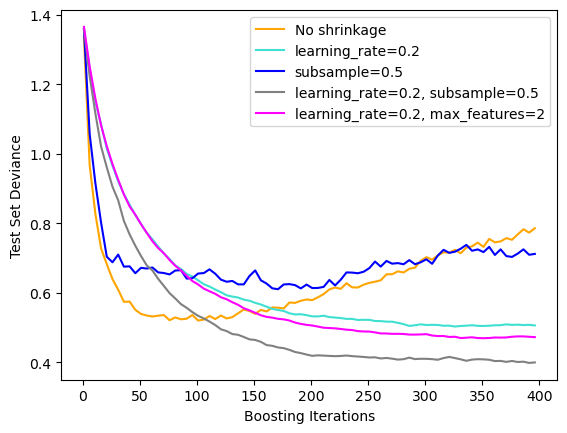

In [25]:
# Authors: The scikit-learn developers
# SPDX-License-Identifier: BSD-3-Clause

import matplotlib.pyplot as plt
import numpy as np

from sklearn import datasets, ensemble
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

X, y = datasets.make_hastie_10_2(n_samples=4000, random_state=1)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=0)

original_params = {
    "n_estimators": 400,
    "max_leaf_nodes": 4,
    "max_depth": None,
    "random_state": 2,
    "min_samples_split": 5,
}

plt.figure()

for label, color, setting in [
    ("No shrinkage", "orange", {"learning_rate": 1.0, "subsample": 1.0}),
    ("learning_rate=0.2", "turquoise", {"learning_rate": 0.2, "subsample": 1.0}),
    ("subsample=0.5", "blue", {"learning_rate": 1.0, "subsample": 0.5}),
    (
        "learning_rate=0.2, subsample=0.5",
        "gray",
        {"learning_rate": 0.2, "subsample": 0.5},
    ),
    (
        "learning_rate=0.2, max_features=2",
        "magenta",
        {"learning_rate": 0.2, "max_features": 2},
    ),
]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params["n_estimators"],), dtype=np.float64)

    for i, y_proba in enumerate(clf.staged_predict_proba(X_test)):
        test_deviance[i] = 2 * log_loss(y_test, y_proba[:, 1])

    plt.plot(
        (np.arange(test_deviance.shape[0]) + 1)[::5],
        test_deviance[::5],
        "-",
        color=color,
        label=label,
    )

plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Test Set Deviance")

plt.show()